In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

import zipfile
with zipfile.ZipFile('../input/plates.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('/kaggle/working/')
    
print('After zip extraction:')
print(os.listdir("/kaggle/working/"))

['sample_submission.csv', 'plates.zip']
After zip extraction:
['__MACOSX', '__notebook_source__.ipynb', 'plates']


In [2]:
data_root = '/kaggle/working/plates/'
print(os.listdir(data_root))

['.DS_Store', 'train', 'test']


In [3]:
import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 21/21 [00:00<00:00, 4490.00it/s]


In [4]:
!ls train

cleaned  dirty


In [5]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy

from torchvision import transforms, models
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [6]:
len(train_dataloader), len(train_dataset)

(4, 32)

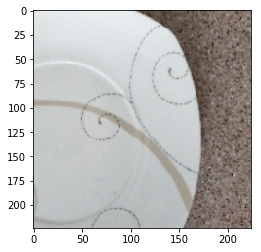

In [7]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

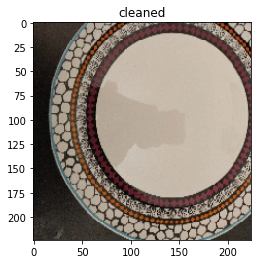

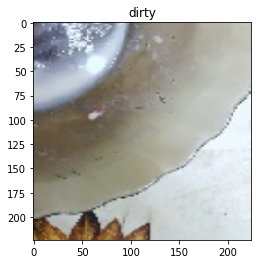

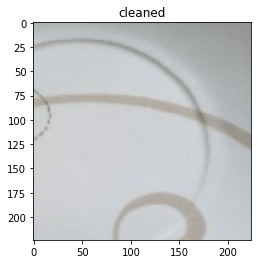

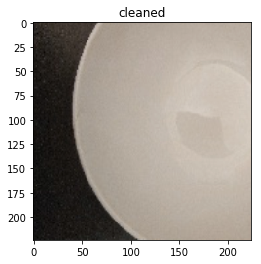

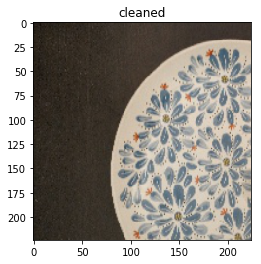

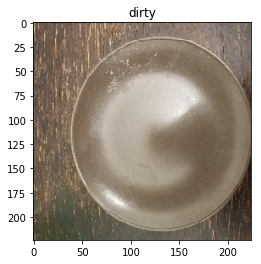

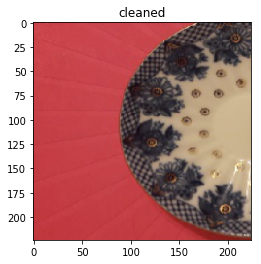

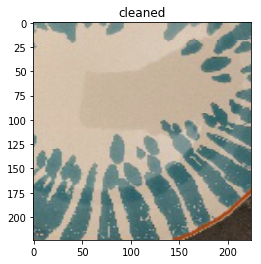

In [8]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [9]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [10]:
model = models.resnet152(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:00<00:00, 122825361.31it/s]


In [11]:
train_model(model, loss, optimizer, scheduler, num_epochs=100);

Epoch 0/99:


100%|██████████| 4/4 [00:01<00:00,  2.57it/s]

train Loss: 0.7680 Acc: 0.5000



100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


val Loss: 0.7261 Acc: 0.5000
Epoch 1/99:


100%|██████████| 4/4 [00:00<00:00,  7.61it/s]

train Loss: 0.6781 Acc: 0.5938



100%|██████████| 1/1 [00:00<00:00,  4.44it/s]

val Loss: 0.6178 Acc: 0.7500
Epoch 2/99:



100%|██████████| 4/4 [00:00<00:00,  7.77it/s]

train Loss: 0.6788 Acc: 0.5312



100%|██████████| 1/1 [00:00<00:00,  4.45it/s]

val Loss: 0.6656 Acc: 0.5000
Epoch 3/99:



100%|██████████| 4/4 [00:00<00:00,  8.23it/s]

train Loss: 0.5243 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  3.73it/s]

val Loss: 0.6273 Acc: 0.6250
Epoch 4/99:



100%|██████████| 4/4 [00:00<00:00,  5.90it/s]

train Loss: 0.5327 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  4.48it/s]

val Loss: 0.5331 Acc: 0.7500
Epoch 5/99:



100%|██████████| 4/4 [00:00<00:00,  8.20it/s]

train Loss: 0.5121 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  4.21it/s]

val Loss: 0.5376 Acc: 0.7500
Epoch 6/99:



100%|██████████| 4/4 [00:00<00:00,  8.21it/s]

train Loss: 0.3731 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  4.47it/s]

val Loss: 0.5427 Acc: 0.5000
Epoch 7/99:



100%|██████████| 4/4 [00:00<00:00,  5.37it/s]

train Loss: 0.4367 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  4.35it/s]

val Loss: 0.5465 Acc: 0.5000
Epoch 8/99:



100%|██████████| 4/4 [00:00<00:00,  8.28it/s]

train Loss: 0.4002 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  4.55it/s]

val Loss: 0.5466 Acc: 0.7500
Epoch 9/99:



100%|██████████| 4/4 [00:00<00:00,  7.92it/s]

train Loss: 0.3945 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  4.45it/s]

val Loss: 0.5598 Acc: 0.7500
Epoch 10/99:



100%|██████████| 4/4 [00:00<00:00,  7.90it/s]

train Loss: 0.3727 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  4.37it/s]

val Loss: 0.5681 Acc: 0.7500
Epoch 11/99:



100%|██████████| 4/4 [00:00<00:00,  8.09it/s]

train Loss: 0.3849 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  4.47it/s]

val Loss: 0.5671 Acc: 0.7500
Epoch 12/99:



100%|██████████| 4/4 [00:00<00:00,  8.16it/s]

train Loss: 0.3969 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  4.54it/s]

val Loss: 0.5675 Acc: 0.7500
Epoch 13/99:



100%|██████████| 4/4 [00:00<00:00,  7.33it/s]

train Loss: 0.4220 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  4.46it/s]

val Loss: 0.5569 Acc: 0.7500
Epoch 14/99:



100%|██████████| 4/4 [00:00<00:00,  8.18it/s]

train Loss: 0.4382 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  4.46it/s]

val Loss: 0.5572 Acc: 0.7500
Epoch 15/99:



100%|██████████| 4/4 [00:00<00:00,  8.50it/s]

train Loss: 0.4437 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  4.51it/s]

val Loss: 0.5579 Acc: 0.7500
Epoch 16/99:



100%|██████████| 4/4 [00:00<00:00,  5.45it/s]

train Loss: 0.4143 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  3.22it/s]

val Loss: 0.5575 Acc: 0.7500
Epoch 17/99:



100%|██████████| 4/4 [00:00<00:00,  8.15it/s]

train Loss: 0.4899 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  4.48it/s]

val Loss: 0.5378 Acc: 0.7500
Epoch 18/99:



100%|██████████| 4/4 [00:00<00:00,  8.17it/s]

train Loss: 0.3711 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  4.53it/s]

val Loss: 0.5579 Acc: 0.7500
Epoch 19/99:



100%|██████████| 4/4 [00:00<00:00,  8.29it/s]

train Loss: 0.3395 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  4.49it/s]

val Loss: 0.5579 Acc: 0.7500
Epoch 20/99:



100%|██████████| 4/4 [00:00<00:00,  8.15it/s]

train Loss: 0.3812 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  4.48it/s]

val Loss: 0.5444 Acc: 0.7500
Epoch 21/99:



100%|██████████| 4/4 [00:00<00:00,  8.13it/s]

train Loss: 0.3522 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  4.44it/s]

val Loss: 0.5409 Acc: 0.7500
Epoch 22/99:



100%|██████████| 4/4 [00:00<00:00,  7.65it/s]

train Loss: 0.4227 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  4.47it/s]

val Loss: 0.5406 Acc: 0.7500
Epoch 23/99:



100%|██████████| 4/4 [00:00<00:00,  6.45it/s]

train Loss: 0.3707 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  4.48it/s]

val Loss: 0.5361 Acc: 0.7500
Epoch 24/99:



100%|██████████| 4/4 [00:00<00:00,  5.14it/s]

train Loss: 0.4851 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  4.46it/s]

val Loss: 0.5492 Acc: 0.7500
Epoch 25/99:



100%|██████████| 4/4 [00:00<00:00,  4.91it/s]

train Loss: 0.3884 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  4.43it/s]

val Loss: 0.5698 Acc: 0.7500
Epoch 26/99:



100%|██████████| 4/4 [00:00<00:00,  6.86it/s]

train Loss: 0.4240 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  4.43it/s]

val Loss: 0.5378 Acc: 0.7500
Epoch 27/99:



100%|██████████| 4/4 [00:00<00:00,  5.67it/s]

train Loss: 0.3797 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  3.10it/s]

val Loss: 0.5468 Acc: 0.7500
Epoch 28/99:



100%|██████████| 4/4 [00:00<00:00,  1.95it/s]

train Loss: 0.4203 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

val Loss: 0.5684 Acc: 0.7500
Epoch 29/99:



100%|██████████| 4/4 [00:00<00:00,  5.13it/s]

train Loss: 0.3933 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  3.10it/s]

val Loss: 0.5505 Acc: 0.7500
Epoch 30/99:



100%|██████████| 4/4 [00:00<00:00,  5.29it/s]

train Loss: 0.3602 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  3.14it/s]

val Loss: 0.5595 Acc: 0.7500
Epoch 31/99:



100%|██████████| 4/4 [00:00<00:00,  2.49it/s]

train Loss: 0.4475 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  3.14it/s]

val Loss: 0.5554 Acc: 0.7500
Epoch 32/99:



100%|██████████| 4/4 [00:00<00:00,  5.28it/s]

train Loss: 0.5582 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  3.15it/s]

val Loss: 0.5481 Acc: 0.7500
Epoch 33/99:



100%|██████████| 4/4 [00:00<00:00,  5.20it/s]

train Loss: 0.4217 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  3.10it/s]

val Loss: 0.5526 Acc: 0.7500
Epoch 34/99:



100%|██████████| 4/4 [00:00<00:00,  5.23it/s]

train Loss: 0.4192 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  3.13it/s]

val Loss: 0.5313 Acc: 0.7500
Epoch 35/99:



100%|██████████| 4/4 [00:00<00:00,  5.08it/s]

train Loss: 0.4962 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  3.11it/s]

val Loss: 0.5487 Acc: 0.6250
Epoch 36/99:



100%|██████████| 4/4 [00:00<00:00,  5.11it/s]

train Loss: 0.4107 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  3.14it/s]

val Loss: 0.5496 Acc: 0.7500
Epoch 37/99:



100%|██████████| 4/4 [00:01<00:00,  3.98it/s]

train Loss: 0.4327 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  3.21it/s]

val Loss: 0.5555 Acc: 0.7500
Epoch 38/99:



100%|██████████| 4/4 [00:00<00:00,  5.15it/s]

train Loss: 0.3947 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  3.16it/s]

val Loss: 0.5509 Acc: 0.7500
Epoch 39/99:



100%|██████████| 4/4 [00:00<00:00,  5.04it/s]

train Loss: 0.4332 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  3.06it/s]

val Loss: 0.5352 Acc: 0.7500
Epoch 40/99:



100%|██████████| 4/4 [00:00<00:00,  5.13it/s]

train Loss: 0.3729 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  3.12it/s]

val Loss: 0.5383 Acc: 0.7500
Epoch 41/99:



100%|██████████| 4/4 [00:00<00:00,  5.09it/s]

train Loss: 0.3907 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  3.14it/s]

val Loss: 0.5221 Acc: 0.7500
Epoch 42/99:



100%|██████████| 4/4 [00:00<00:00,  5.15it/s]

train Loss: 0.3948 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  3.11it/s]

val Loss: 0.5449 Acc: 0.7500
Epoch 43/99:



100%|██████████| 4/4 [00:00<00:00,  4.98it/s]

train Loss: 0.4081 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  3.18it/s]

val Loss: 0.5342 Acc: 0.7500
Epoch 44/99:



100%|██████████| 4/4 [00:00<00:00,  5.24it/s]

train Loss: 0.3527 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.08it/s]

val Loss: 0.5537 Acc: 0.7500
Epoch 45/99:



100%|██████████| 4/4 [00:00<00:00,  4.24it/s]

train Loss: 0.3962 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  2.49it/s]

val Loss: 0.5581 Acc: 0.7500
Epoch 46/99:



100%|██████████| 4/4 [00:00<00:00,  4.70it/s]

train Loss: 0.3939 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  3.17it/s]

val Loss: 0.5530 Acc: 0.7500
Epoch 47/99:



100%|██████████| 4/4 [00:00<00:00,  5.14it/s]

train Loss: 0.4130 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  3.06it/s]

val Loss: 0.5519 Acc: 0.7500
Epoch 48/99:



100%|██████████| 4/4 [00:00<00:00,  5.20it/s]

train Loss: 0.4011 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.12it/s]

val Loss: 0.5362 Acc: 0.7500
Epoch 49/99:



100%|██████████| 4/4 [00:00<00:00,  4.58it/s]

train Loss: 0.3365 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  4.40it/s]

val Loss: 0.5441 Acc: 0.7500
Epoch 50/99:



100%|██████████| 4/4 [00:00<00:00,  8.34it/s]

train Loss: 0.4294 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  4.42it/s]

val Loss: 0.5380 Acc: 0.7500
Epoch 51/99:



100%|██████████| 4/4 [00:00<00:00,  8.14it/s]

train Loss: 0.4174 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  4.43it/s]

val Loss: 0.5530 Acc: 0.7500
Epoch 52/99:



100%|██████████| 4/4 [00:00<00:00,  8.00it/s]

train Loss: 0.4190 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  4.36it/s]

val Loss: 0.5538 Acc: 0.7500
Epoch 53/99:



100%|██████████| 4/4 [00:00<00:00,  8.22it/s]

train Loss: 0.3401 Acc: 0.9688



100%|██████████| 1/1 [00:00<00:00,  4.36it/s]

val Loss: 0.5490 Acc: 0.7500
Epoch 54/99:



100%|██████████| 4/4 [00:00<00:00,  8.11it/s]

train Loss: 0.4176 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  4.36it/s]

val Loss: 0.5589 Acc: 0.7500
Epoch 55/99:



100%|██████████| 4/4 [00:00<00:00,  7.93it/s]

train Loss: 0.4377 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  4.37it/s]

val Loss: 0.5528 Acc: 0.7500
Epoch 56/99:



100%|██████████| 4/4 [00:00<00:00,  8.24it/s]

train Loss: 0.4290 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  3.74it/s]

val Loss: 0.5638 Acc: 0.7500
Epoch 57/99:



100%|██████████| 4/4 [00:00<00:00,  6.56it/s]

train Loss: 0.3196 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  4.35it/s]

val Loss: 0.5568 Acc: 0.7500
Epoch 58/99:



100%|██████████| 4/4 [00:00<00:00,  8.06it/s]

train Loss: 0.3912 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  2.63it/s]

val Loss: 0.5453 Acc: 0.7500
Epoch 59/99:



100%|██████████| 4/4 [00:00<00:00,  6.32it/s]

train Loss: 0.3902 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  4.34it/s]

val Loss: 0.5404 Acc: 0.7500
Epoch 60/99:



100%|██████████| 4/4 [00:00<00:00,  8.21it/s]

train Loss: 0.3723 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  4.01it/s]

val Loss: 0.5489 Acc: 0.7500
Epoch 61/99:



100%|██████████| 4/4 [00:00<00:00,  8.27it/s]

train Loss: 0.4091 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  4.29it/s]

val Loss: 0.5538 Acc: 0.7500
Epoch 62/99:



100%|██████████| 4/4 [00:00<00:00,  8.12it/s]

train Loss: 0.4077 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  4.37it/s]

val Loss: 0.5662 Acc: 0.6250
Epoch 63/99:



100%|██████████| 4/4 [00:00<00:00,  7.75it/s]

train Loss: 0.4480 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  4.46it/s]

val Loss: 0.5580 Acc: 0.7500
Epoch 64/99:



100%|██████████| 4/4 [00:00<00:00,  5.59it/s]

train Loss: 0.3879 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  4.39it/s]

val Loss: 0.5663 Acc: 0.7500
Epoch 65/99:



100%|██████████| 4/4 [00:00<00:00,  7.76it/s]

train Loss: 0.3992 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  4.38it/s]

val Loss: 0.5758 Acc: 0.7500
Epoch 66/99:



100%|██████████| 4/4 [00:00<00:00,  7.93it/s]

train Loss: 0.4067 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  4.46it/s]

val Loss: 0.5718 Acc: 0.7500
Epoch 67/99:



100%|██████████| 4/4 [00:00<00:00,  7.79it/s]

train Loss: 0.3887 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  4.20it/s]

val Loss: 0.5606 Acc: 0.7500
Epoch 68/99:



100%|██████████| 4/4 [00:00<00:00,  8.14it/s]

train Loss: 0.3722 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  3.79it/s]

val Loss: 0.5717 Acc: 0.6250
Epoch 69/99:



100%|██████████| 4/4 [00:00<00:00,  6.10it/s]

train Loss: 0.4112 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  3.91it/s]

val Loss: 0.5753 Acc: 0.6250
Epoch 70/99:



100%|██████████| 4/4 [00:00<00:00,  7.54it/s]

train Loss: 0.3704 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  4.32it/s]

val Loss: 0.5762 Acc: 0.6250
Epoch 71/99:



100%|██████████| 4/4 [00:00<00:00,  8.31it/s]

train Loss: 0.4590 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  4.43it/s]

val Loss: 0.5622 Acc: 0.7500
Epoch 72/99:



100%|██████████| 4/4 [00:00<00:00,  8.25it/s]

train Loss: 0.3795 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  4.32it/s]

val Loss: 0.5668 Acc: 0.7500
Epoch 73/99:



100%|██████████| 4/4 [00:00<00:00,  8.07it/s]

train Loss: 0.3500 Acc: 0.9688



100%|██████████| 1/1 [00:00<00:00,  4.42it/s]

val Loss: 0.5513 Acc: 0.7500
Epoch 74/99:



100%|██████████| 4/4 [00:00<00:00,  8.19it/s]

train Loss: 0.3895 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  4.36it/s]

val Loss: 0.5690 Acc: 0.7500
Epoch 75/99:



100%|██████████| 4/4 [00:00<00:00,  8.27it/s]

train Loss: 0.4479 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  4.23it/s]

val Loss: 0.5588 Acc: 0.7500
Epoch 76/99:



100%|██████████| 4/4 [00:00<00:00,  8.09it/s]

train Loss: 0.4023 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.98it/s]

val Loss: 0.5509 Acc: 0.7500
Epoch 77/99:



100%|██████████| 4/4 [00:00<00:00,  8.39it/s]

train Loss: 0.3658 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  4.38it/s]

val Loss: 0.5504 Acc: 0.7500
Epoch 78/99:



100%|██████████| 4/4 [00:00<00:00,  8.01it/s]

train Loss: 0.4143 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  4.05it/s]

val Loss: 0.5636 Acc: 0.7500
Epoch 79/99:



100%|██████████| 4/4 [00:00<00:00,  6.58it/s]

train Loss: 0.3946 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  4.18it/s]

val Loss: 0.5644 Acc: 0.6250
Epoch 80/99:



100%|██████████| 4/4 [00:00<00:00,  7.78it/s]

train Loss: 0.4585 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  4.34it/s]

val Loss: 0.5611 Acc: 0.6250
Epoch 81/99:



100%|██████████| 4/4 [00:00<00:00,  7.62it/s]

train Loss: 0.3907 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  3.19it/s]

val Loss: 0.5613 Acc: 0.6250
Epoch 82/99:



100%|██████████| 4/4 [00:00<00:00,  7.35it/s]

train Loss: 0.4160 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  4.25it/s]

val Loss: 0.5714 Acc: 0.7500
Epoch 83/99:



100%|██████████| 4/4 [00:00<00:00,  8.00it/s]

train Loss: 0.3923 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  4.34it/s]

val Loss: 0.5833 Acc: 0.7500
Epoch 84/99:



100%|██████████| 4/4 [00:00<00:00,  7.92it/s]

train Loss: 0.3623 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  4.39it/s]

val Loss: 0.5708 Acc: 0.7500
Epoch 85/99:



100%|██████████| 4/4 [00:00<00:00,  8.17it/s]

train Loss: 0.3599 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  4.21it/s]

val Loss: 0.5638 Acc: 0.7500
Epoch 86/99:



100%|██████████| 4/4 [00:00<00:00,  8.12it/s]

train Loss: 0.3613 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  4.27it/s]

val Loss: 0.5727 Acc: 0.7500
Epoch 87/99:



100%|██████████| 4/4 [00:00<00:00,  8.19it/s]

train Loss: 0.3540 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  4.41it/s]

val Loss: 0.5831 Acc: 0.7500
Epoch 88/99:



100%|██████████| 4/4 [00:00<00:00,  8.24it/s]

train Loss: 0.4040 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  4.29it/s]

val Loss: 0.5787 Acc: 0.7500
Epoch 89/99:



100%|██████████| 4/4 [00:00<00:00,  8.21it/s]

train Loss: 0.4034 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  4.27it/s]

val Loss: 0.5827 Acc: 0.7500
Epoch 90/99:



100%|██████████| 4/4 [00:00<00:00,  8.18it/s]

train Loss: 0.4139 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  4.41it/s]

val Loss: 0.5809 Acc: 0.7500
Epoch 91/99:



100%|██████████| 4/4 [00:00<00:00,  8.08it/s]

train Loss: 0.3862 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  4.37it/s]

val Loss: 0.5776 Acc: 0.7500
Epoch 92/99:



100%|██████████| 4/4 [00:00<00:00,  8.02it/s]

train Loss: 0.3760 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  4.42it/s]

val Loss: 0.5773 Acc: 0.7500
Epoch 93/99:



100%|██████████| 4/4 [00:00<00:00,  8.28it/s]

train Loss: 0.3715 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  4.37it/s]

val Loss: 0.5710 Acc: 0.7500
Epoch 94/99:



100%|██████████| 4/4 [00:00<00:00,  7.16it/s]

train Loss: 0.4162 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  3.36it/s]

val Loss: 0.5607 Acc: 0.7500
Epoch 95/99:



100%|██████████| 4/4 [00:00<00:00,  7.87it/s]

train Loss: 0.4069 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  4.37it/s]

val Loss: 0.5703 Acc: 0.7500
Epoch 96/99:



100%|██████████| 4/4 [00:00<00:00,  8.18it/s]

train Loss: 0.3754 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  4.34it/s]

val Loss: 0.5565 Acc: 0.6250
Epoch 97/99:



100%|██████████| 4/4 [00:00<00:00,  8.18it/s]

train Loss: 0.3795 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  4.39it/s]

val Loss: 0.5722 Acc: 0.7500
Epoch 98/99:



100%|██████████| 4/4 [00:00<00:00,  8.17it/s]

train Loss: 0.3156 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  4.33it/s]

val Loss: 0.5653 Acc: 0.7500
Epoch 99/99:



100%|██████████| 4/4 [00:00<00:00,  7.87it/s]

train Loss: 0.4121 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  4.29it/s]

val Loss: 0.5713 Acc: 0.7500


In [12]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test/unknown'

In [13]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('/kaggle/working/test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [14]:
test_dataset

Dataset ImageFolderWithPaths
    Number of datapoints: 744
    Root location: /kaggle/working/test

In [15]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████| 93/93 [00:04<00:00, 20.22it/s]


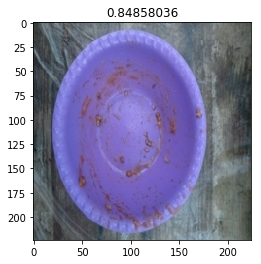

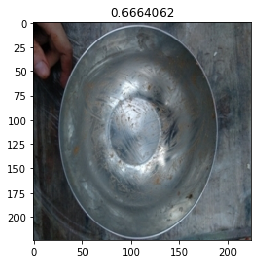

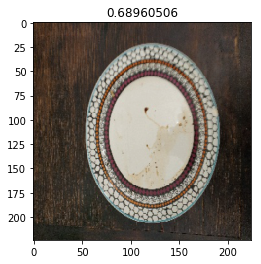

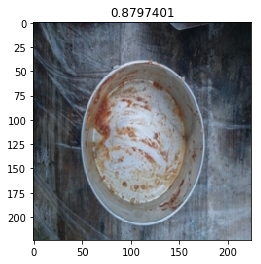

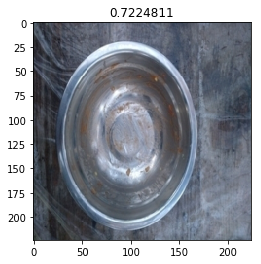

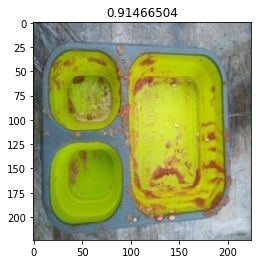

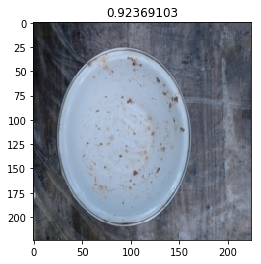

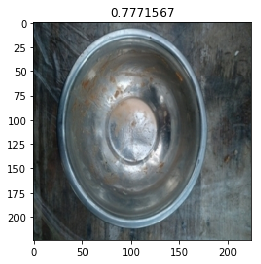

In [16]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [17]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [18]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/kaggle/working/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

,label
id,
0000,cleaned
0001,cleaned
0002,cleaned
0003,cleaned
0004,cleaned
0005,cleaned


In [19]:
submission_df.to_csv('submission.csv')

In [20]:
!rm -rf train val test